# Train Likelihood Estimator

We train the ALICE likelihood ratio estimator on data with varying dimensions in its input. 

In [83]:
import numpy as np
import logging
import matplotlib
from matplotlib import pyplot as plt
from pylab import legend
%matplotlib inline

logging.basicConfig(
    format='%(asctime)-5.5s %(name)-20.20s %(levelname)-7.7s %(message)s',
    datefmt='%H:%M',
    level=logging.INFO
)
for key in logging.Logger.manager.loggerDict:
    if "madminer" not in key:
        logging.getLogger(key).setLevel(logging.WARNING)
        
from madminer import sampling
from madminer.sampling import SampleAugmenter
from madminer.ml import ParameterizedRatioEstimator
from madminer.core import MadMiner
from scipy.stats import poisson
from madminer.delphes import DelphesReader
from madminer.sampling import combine_and_shuffle

def calculate_invariant_mass(all_x):
    """Calculates invariant mass given jet four-momenta."""
    eta0 = all_x[:,0]
    phi0 = all_x[:,1]
    pt0  = all_x[:,2]
    m0   = all_x[:,3]
    eta1 = all_x[:,4]
    phi1 = all_x[:,5]
    pt1  = all_x[:,6]
    m1   = all_x[:,7]
    return  np.sqrt(2 * np.abs(pt0) * np.abs(pt1) * (np.cosh(eta0 - eta1) - np.cos(phi0-phi1)))

def twod_data(all_x):
    """Calculates an array containing the invariant mass and y_jj given jet four-momenta."""
    invm = calculate_invariant_mass(all_x)
    eta0 = all_x[:,0]
    phi0 = all_x[:,1]
    pt0  = all_x[:,2]
    m0   = all_x[:,3]
    eta1 = all_x[:,4]
    phi1 = all_x[:,5]
    pt1  = all_x[:,6]
    m1   = all_x[:,7]
    delta_yjj = eta0 - eta1
    return np.concatenate([invm[:,None], delta_yjj[:,None]], axis=1)

def run_pseudoexperiments(log_likelihood_ratio, x_length, y_length, N, num_experiments):
    """Calculates expected p-values for subset of test set containing N events using num_experiments trials."""
    pseudoexperiment_results = []
    for _ in range(num_experiments):
        test_points = np.random.choice(log_likelihood_ratio.shape[1], N)  
        pseudo_log_r = np.sum(log_likelihood_ratio[:,test_points] ,axis=1)
        pseudo_log_r = pseudo_log_r.reshape((x_length, y_length))
        pseudo_log_r_wrt_mle = pseudo_log_r - pseudo_log_r.max()
        pseudo_pvals = np.exp(pseudo_log_r_wrt_mle)
        pseudoexperiment_results += [pseudo_pvals]
    return np.mean(np.array(pseudoexperiment_results),axis=0)

Load in training data and validation data of (unweighted) dijet events.

In [84]:
miner = MadMiner()
sampler = SampleAugmenter('meta/delphes_data_shuffled_g02.h5')
miner.load("meta/setup.h5")

# 300, 2.0
training_theta_ref = 'benchmark_65'
# 285, 1.2
testing_theta_true = 'benchmark_28'

x, theta0, theta1, y, r_xz, t_xz, n_effective = sampler.sample_train_ratio(
    theta0=sampling.benchmarks(list(sampler.benchmarks.keys())),
    theta1=sampling.benchmark(training_theta_ref),
    n_samples=1000000,
    folder='./meta/samples',
    filename='train_ratio',
    sample_only_from_closest_benchmark=True,
    return_individual_n_effective=True,
)
x_test,_,_ = sampler.sample_test(
    theta=sampling.benchmark(testing_theta_true),
    n_samples=10000,
    folder='./meta/samples',
    filename='test',
)

01:22 madminer.analysis    INFO    Loading data from meta/delphes_data_shuffled_g02.h5
01:22 madminer.analysis    INFO    Found 2 parameters
01:22 madminer.analysis    INFO    Did not find nuisance parameters
01:22 madminer.analysis    INFO    Found 121 benchmarks, of which 121 physical
01:22 madminer.analysis    INFO    Found 8 observables
01:22 madminer.analysis    INFO    Found 649198 events
01:22 madminer.analysis    INFO      4123 signal events sampled from benchmark benchmark_1
01:22 madminer.analysis    INFO      4132 signal events sampled from benchmark benchmark_2
01:22 madminer.analysis    INFO      4454 signal events sampled from benchmark benchmark_3
01:22 madminer.analysis    INFO      4797 signal events sampled from benchmark benchmark_4
01:22 madminer.analysis    INFO      5488 signal events sampled from benchmark benchmark_5
01:22 madminer.analysis    INFO      6245 signal events sampled from benchmark benchmark_6
01:22 madminer.analysis    INFO      6973 signal events 

01:22 madminer.analysis    INFO      5975 signal events sampled from benchmark benchmark_94
01:22 madminer.analysis    INFO      6652 signal events sampled from benchmark benchmark_95
01:22 madminer.analysis    INFO      7280 signal events sampled from benchmark benchmark_96
01:22 madminer.analysis    INFO      7832 signal events sampled from benchmark benchmark_97
01:22 madminer.analysis    INFO      8212 signal events sampled from benchmark benchmark_98
01:22 madminer.analysis    INFO      4063 signal events sampled from benchmark benchmark_100
01:22 madminer.analysis    INFO      4122 signal events sampled from benchmark benchmark_101
01:22 madminer.analysis    INFO      4285 signal events sampled from benchmark benchmark_102
01:22 madminer.analysis    INFO      4655 signal events sampled from benchmark benchmark_103
01:22 madminer.analysis    INFO      5252 signal events sampled from benchmark benchmark_104
01:22 madminer.analysis    INFO      5917 signal events sampled from benchm

01:22 madminer.core        INFO       benchmark_69: mzp = 3.05e+02, gzp = 0.60
01:22 madminer.core        INFO       benchmark_70: mzp = 3.05e+02, gzp = 0.80
01:22 madminer.core        INFO       benchmark_71: mzp = 3.05e+02, gzp = 1.00
01:22 madminer.core        INFO       benchmark_72: mzp = 3.05e+02, gzp = 1.20
01:22 madminer.core        INFO       benchmark_73: mzp = 3.05e+02, gzp = 1.40
01:22 madminer.core        INFO       benchmark_74: mzp = 3.05e+02, gzp = 1.60
01:22 madminer.core        INFO       benchmark_75: mzp = 3.05e+02, gzp = 1.80
01:22 madminer.core        INFO       benchmark_76: mzp = 3.05e+02, gzp = 2.00
01:22 madminer.core        INFO       benchmark_77: mzp = 3.10e+02, gzp = 0.00e+00
01:22 madminer.core        INFO       benchmark_78: mzp = 3.10e+02, gzp = 0.20
01:22 madminer.core        INFO       benchmark_79: mzp = 3.10e+02, gzp = 0.40
01:22 madminer.core        INFO       benchmark_80: mzp = 3.10e+02, gzp = 0.60
01:22 madminer.core        INFO       benchmark_

01:25 madminer.sampling    INFO    Effective number of samples: mean 1234.0000000000002, with individual thetas ranging from 1234.0000000000002 to 1234.0000000000002


**WARNING**: The cell below should usually not be run. This will generate a new testing set that is completely independent of the training set, as an extra precaution to avoid any possibility of contamination of testing data effecting the training of the model. We only ever use this set to report expected behavior in the paper, all tuning of parameters is done to fit the validation set sampled in the previous cell.

In [85]:
## Generate Testing data
###########################################################################################
mg_dir = '/home/kwl/Documents/hep/MG5_aMC_v2_6_5'    # Points to Madgraph Install     
events_dir = '/udd/madminer_events_test_set/'            # Points to directory to save events 
                                                     # (where the run_XX folders are saved)
setup_file = 'meta/setup_test_set.h5'
###########################################################################################
miner = MadMiner()

miner.add_parameter(
    lha_block='mass',
    lha_id=56,
    parameter_name='mzp',
    morphing_max_power=0,
)

miner.add_parameter(
    lha_block='dminputs',
    lha_id=2,
    parameter_name='gzp',
    morphing_max_power=0,
)

miner.add_benchmark({'mzp': 285.0,'gzp': 1.2})

miner.save(setup_file)

miner.run(
    mg_directory=mg_dir,
    mg_process_directory=events_dir+'signal_pythia_dummy',
    proc_card_file='cards/proc_card.dat',
    param_card_template_file='cards/param_card.dat',
    pythia8_card_file='cards/pythia8_card.dat',
    run_card_file='cards/run_card_signal.dat',
    log_directory='logs/signal'
)

delphes = DelphesReader(setup_file)

delphes.add_sample(
    lhe_filename=events_dir + 'signal_pythia_dummy/Events/run_01/unweighted_events.lhe.gz',
    hepmc_filename=events_dir + 'signal_pythia_dummy/Events/run_01/tag_1_pythia8_events.hepmc.gz',
    sampled_from_benchmark='benchmark_0',
    is_background=False
)

delphes.run_delphes(
    delphes_directory=mg_dir + '/Delphes',
    delphes_card='cards/delphes_card.dat',
    log_file='logs/delphes.log',
)

delphes.reset_cuts()

delphes.add_observable(
    'eta0',
    'j[0].eta',
    required=True
)
delphes.add_observable(
    'phi0',
    'j[0].phi()',
    required=True,
)
delphes.add_observable(
    'pt0',
    'j[0].pt',
    required=True,
)
delphes.add_observable(
    'm0',
    'j[0].m',
    required=True,
)
delphes.add_observable(
    'eta1',
    'j[1].eta',
    required=True,
)
delphes.add_observable(
    'phi1',
    'j[1].phi()',
    required=True,
)
delphes.add_observable(
    'pt1',
    'j[1].pt',
    required=True,
)
delphes.add_observable(
    'm1',
    'j[1].m',
    required=True,
)

#### Cuts ####
invariant_mass = 'sqrt(2*abs(j[0].pt)*abs(j[1].pt)*(cosh(j[0].eta-j[1].eta)-cos(j[0].phi()-j[1].phi())))'
delphes.add_cut(invariant_mass + '>150')
delphes.add_cut(invariant_mass + '<450')

#### Process & Export ####

delphes.analyse_delphes_samples()
delphes.save('meta/delphes_data_test_set.h5')
combine_and_shuffle(
    ['meta/delphes_data_test_set.h5'],
    'meta/delphes_data_shuffled_test_set.h5'
)

01:29 madminer.core        INFO    Added parameter mzp (LHA: mass 56, maximal power in squared ME: (0,), range: (0.0, 1.0))
01:29 madminer.core        INFO    Added parameter gzp (LHA: dminputs 2, maximal power in squared ME: (0,), range: (0.0, 1.0))
01:29 madminer.core        INFO    Added benchmark benchmark_0: mzp = 2.85e+02, gzp = 1.20)
01:29 madminer.core        INFO    Saving setup (without morphing) to meta/setup_test_set.h5
01:29 madminer.utils.inter INFO    Generating MadGraph process folder from cards/proc_card.dat at /udd/madminer_events_test_set/signal_pythia_dummy
01:29 madminer.core        INFO    Run 0
01:29 madminer.core        INFO      Sampling from benchmark: benchmark_0
01:29 madminer.core        INFO      Original run card:       cards/run_card_signal.dat
01:29 madminer.core        INFO      Original Pythia8 card:   cards/pythia8_card.dat
01:29 madminer.core        INFO      Copied run card:         /madminer/cards/run_card_0.dat
01:29 madminer.core        INFO    

In [87]:
sampler_test_set = SampleAugmenter('meta/delphes_data_shuffled_test_set.h5')

x_test,_,_ = sampler_test_set.sample_test(
    theta=sampling.benchmark('benchmark_0'),
    n_samples=10000,
    folder='./meta/samples',
    filename='test',
)

01:41 madminer.analysis    INFO    Loading data from meta/delphes_data_shuffled_test_set.h5
01:41 madminer.analysis    INFO    Found 2 parameters
01:41 madminer.analysis    INFO    Did not find nuisance parameters
01:41 madminer.analysis    INFO    Found 1 benchmarks, of which 1 physical
01:41 madminer.analysis    INFO    Found 8 observables
01:41 madminer.analysis    INFO    Found 12423 events
01:41 madminer.analysis    INFO      12423 signal events sampled from benchmark benchmark_0
01:41 madminer.analysis    INFO    Did not find morphing setup.
01:41 madminer.analysis    INFO    Did not find nuisance morphing setup
01:41 madminer.sampling    INFO    Extracting evaluation sample. Sampling according to benchmark_0
01:41 madminer.sampling    INFO    Starting sampling serially
01:41 madminer.sampling    INFO    Sampling from parameter point 1 / 1
01:41 madminer.sampling    INFO    Effective number of samples: mean 2483.9999999999995, with individual thetas ranging from 2483.999999999999

## ALICE results on full input

Set hyperparameters and train ALICE likelihood ratio estimator on full input (four-momenta of both jets)

In [ ]:
estimator = ParameterizedRatioEstimator(
    n_hidden=(12,12,12),
)

# Default activation is tanh()
train_loss, val_loss = estimator.train(
    method='alice',
    theta=theta0,
    x=x,
    y=y,
    r_xz=r_xz,
    initial_lr = .0022,
    final_lr = .0001,
    batch_size = 128,
    optimizer='amsgrad',
    n_epochs=100,
    limit_samplesize=1000000,
    scale_parameters=True
)

#estimator.save('models/alice')

Set parameters regarding how we test our model.

In [89]:
grid_res = 26
n_test_events = 50
n_experiments = 500

theta_m = np.linspace(275.,325.,grid_res)
theta_g = np.linspace(0.,2.,grid_res)

theta_horizontal, theta_vertical = np.meshgrid(theta_m, theta_g)
theta_grid = np.hstack((theta_horizontal.reshape((-1,1)), theta_vertical.reshape((-1,1))))
np.save('meta/samples/theta_grid.npy', theta_grid)

Use our trained model to evaluate the likelihood ratios of the validation set at each point in theta_grid.

In [90]:
estimator = ParameterizedRatioEstimator(
    n_hidden=(12,12,12),
)

estimator.load('models/alice')

log_r_hat, _ = estimator.evaluate_log_likelihood_ratio(
    theta=theta_grid,
    x=x_test,
    evaluate_score=False,
    test_all_combinations=True
)

01:41 madminer.ml          INFO    Loading model from models/alice
01:41 madminer.ml          INFO    Loading evaluation data
01:41 madminer.ml          INFO    Starting ratio evaluation for 6760000 x-theta combinations
01:42 madminer.ml          INFO    Evaluation done


Plot p-values over the $\theta$-plane

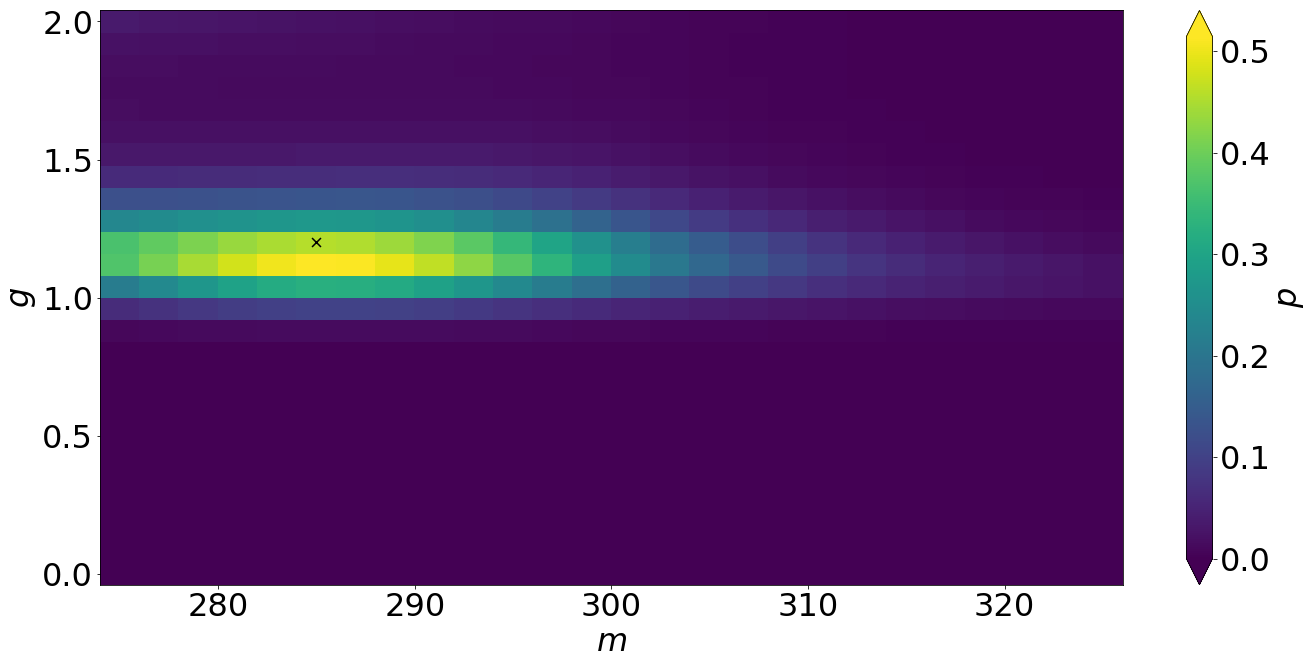

In [122]:
bin_size_m = theta_m[1] - theta_m[0]
bin_size_g = theta_g[1] - theta_g[0]

# Shift so that the grid points we evaluated are in the center of a cell.
edges_m = np.linspace(theta_m[0] - bin_size_m/2, theta_m[-1] + bin_size_m/2, len(theta_m)+1)
edges_g = np.linspace(theta_g[0] - bin_size_g/2, theta_g[-1] + bin_size_g/2, len(theta_g)+1)

# Calculate p_theta at each point in theta_grid using the Neyman construction.
pvals = run_pseudoexperiments(log_r_hat, theta_m.shape[0],theta_g.shape[0], n_test_events, n_experiments)

fig = plt.figure(figsize=(20,10))
ax = plt.gca()
cmin, cmax = np.min(pvals), np.max(pvals)
pcm = ax.pcolormesh(edges_m, edges_g, pvals,
                    norm=matplotlib.colors.Normalize(vmin=cmin, vmax=cmax),
                    cmap='viridis')
cbar = fig.colorbar(pcm, ax=ax, extend='both')

plt.scatter(sampler.benchmarks[testing_theta_true]['mzp'], sampler.benchmarks[testing_theta_true]['gzp'], s=80., color='black', marker='x')

plt.xlabel(r'$m$')
plt.ylabel(r'$g$')
cbar.set_label(r'$p$')

plt.tight_layout()
plt.show()

## Histogram results on invariant mass

Use training data to calculate $r(m_{jj}|\theta)$ for each benchmark $\theta$ that was sampled.

In [92]:
theta_m_lowres= np.linspace(275., 325., 11)
theta_g_lowres = np.linspace(0., 2., 11)
theta_horizontal_lowres, theta_vertical_lowres = np.meshgrid(theta_m_lowres, theta_g_lowres)
theta_grid_lowres = np.hstack((theta_horizontal_lowres.reshape((-1,1)), theta_vertical_lowres.reshape((-1,1))))
np.save('meta/samples/theta_grid_lowres.npy', theta_grid_lowres)

invm_bins = np.linspace(150., 450., 16)
lr_hists = np.zeros(shape=[theta_grid_lowres.shape[0], invm_bins.shape[0]-1])

# Histograms of events in the training set
for j in range(len(theta_g_lowres)):
    for i in range(len(theta_m_lowres)):
        m = theta_m_lowres[i]
        g = theta_g_lowres[j]
        index = j * theta_g_lowres.shape[0] + i
        lr_hists[index], _ = np.histogram(calculate_invariant_mass(x)[np.where((np.isclose(theta0[:,0],m)) \
                                * (np.isclose(theta0[:,1],g)) * (np.isclose(y[:,0],0)))[0]], bins=invm_bins)

Use this likelihood ratio to calculate the likelihood ratio of all events in the test set.

In [93]:
ref_theory_i = np.where(np.isclose(theta_m_lowres, sampler.benchmarks[training_theta_ref]['mzp']))[0]
ref_theory_j = np.where(np.isclose(theta_g_lowres, sampler.benchmarks[training_theta_ref]['gzp']))[0]
log_rx_training = np.log(lr_hists / lr_hists[ref_theory_i * theta_m_lowres.shape[0] + ref_theory_j])

# For some reason, np.digitize assumes indexing from 1 instead of 0, so we subtract 1.
x_test_bin_assignment = np.digitize(calculate_invariant_mass(x_test), invm_bins)-1
# Use the likelihood ratio from histograms of events in the training set to assign likelihood ratio to test events.
log_r_mjj_test = log_rx_training[:, x_test_bin_assignment]

We show plots of the results and also show the result of the ML likelihood ratio on this lower-resolution grid for comparison. ML result performs much better!

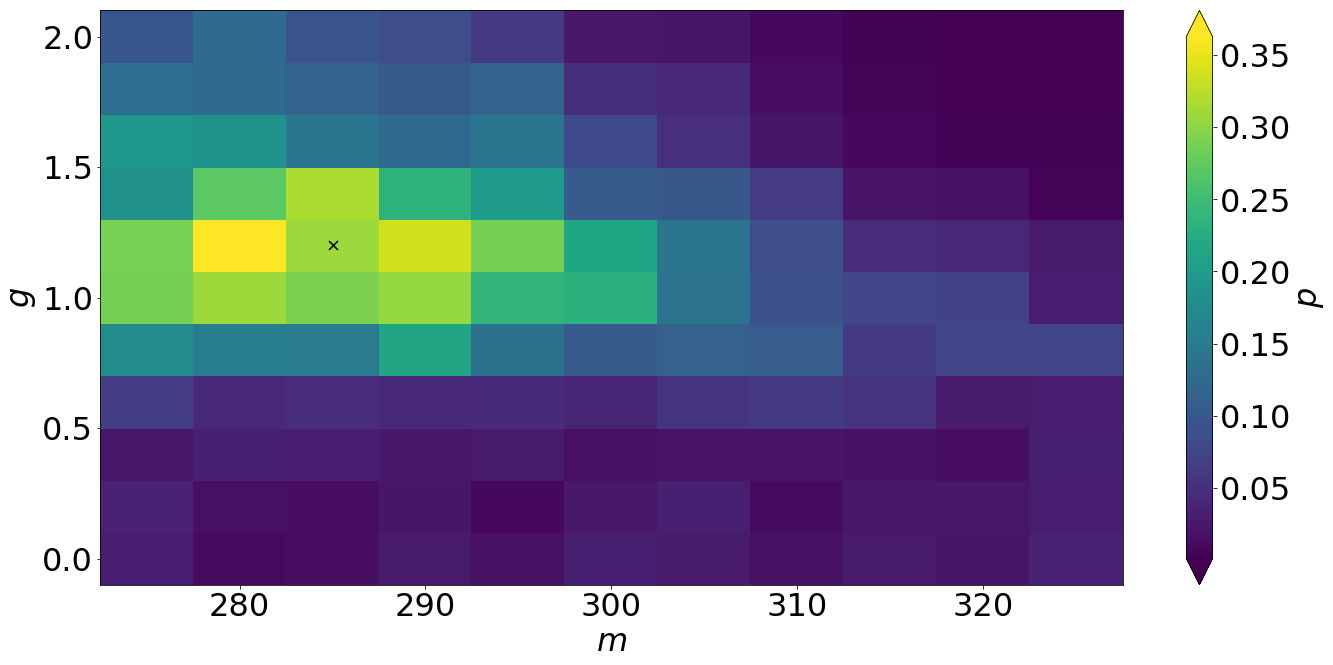

In [128]:
bin_size_m_lowres = theta_m_lowres[1] - theta_m_lowres[0]
bin_size_g_lowres= theta_g_lowres[1] - theta_g_lowres[0]

edges_m_lowres = np.linspace(theta_m_lowres[0] - bin_size_m_lowres/2, theta_m_lowres[-1] + bin_size_m_lowres/2, len(theta_m_lowres)+1)
edges_g_lowres = np.linspace(theta_g_lowres[0] - bin_size_g_lowres/2, theta_g_lowres[-1] + bin_size_g_lowres/2, len(theta_g_lowres)+1)

pvals_hist = run_pseudoexperiments(log_r_mjj_test, theta_m_lowres.shape[0],theta_g_lowres.shape[0], n_test_events, n_experiments)

fig = plt.figure(figsize=(20,10))
ax = plt.gca()
cmin, cmax = np.min(pvals_hist), np.max(pvals_hist)
pcm = ax.pcolormesh(edges_m_lowres, edges_g_lowres, pvals_hist,
                    norm=matplotlib.colors.Normalize(vmin=cmin, vmax=cmax),
                    cmap='viridis')
cbar = fig.colorbar(pcm, ax=ax, extend='both')

plt.scatter(sampler.benchmarks[testing_theta_true]['mzp'], sampler.benchmarks[testing_theta_true]['gzp'], s=80., color='black', marker='x')

plt.xlabel(r'$m$')
plt.ylabel(r'$g$')
cbar.set_label(r'$p$')

plt.tight_layout()
plt.savefig('figures/invm_histogram_pvals.png', format='png')
#plt.savefig('figures/invm_histogram_pvals.svg', format='svg')
plt.show()

02:49 madminer.ml          INFO    Loading model from models/alice
02:49 madminer.ml          INFO    Loading evaluation data
02:49 madminer.ml          INFO    Starting ratio evaluation for 1210000 x-theta combinations
02:49 madminer.ml          INFO    Evaluation done


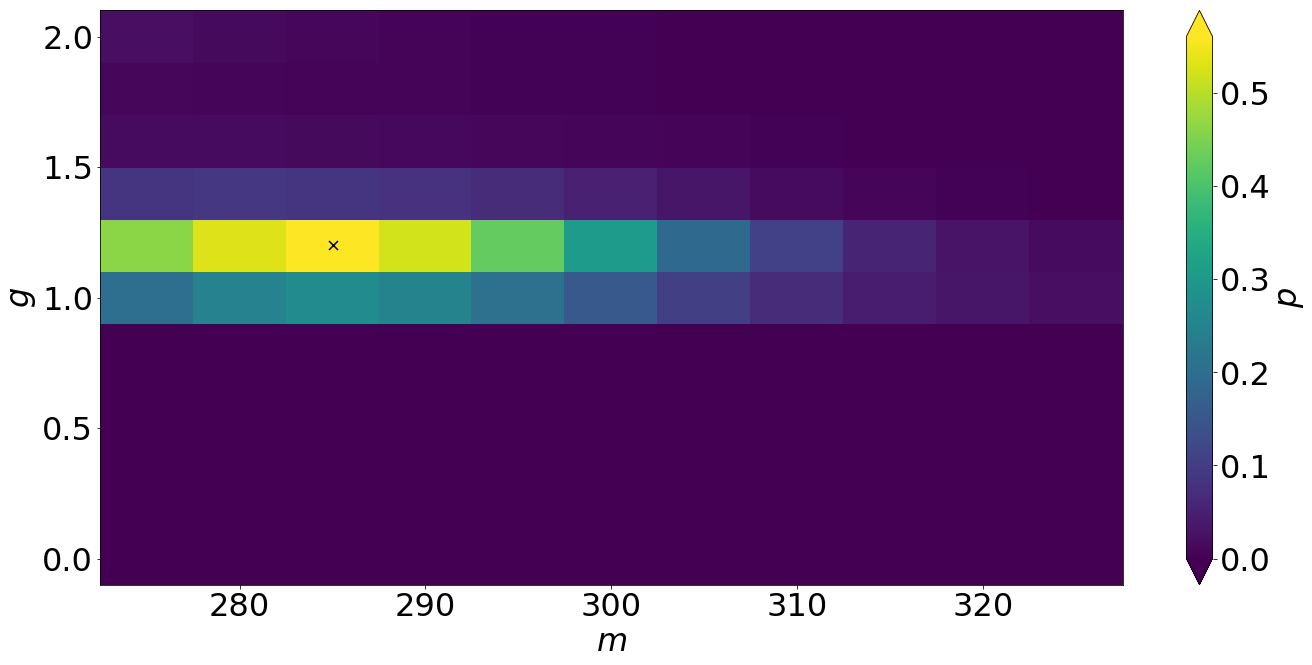

In [124]:
estimator.load('models/alice')

log_r_hat_lowres, _ = estimator.evaluate_log_likelihood_ratio(
    theta=theta_grid_lowres,
    x=x_test,
    evaluate_score=False,
    test_all_combinations=True
)

pvals_lowres = run_pseudoexperiments(log_r_hat_lowres, theta_m_lowres.shape[0],theta_g_lowres.shape[0], n_test_events, n_experiments)

fig = plt.figure(figsize=(20,10))
ax = plt.gca()
cmin, cmax = np.min(pvals_lowres), np.max(pvals_lowres)
pcm = ax.pcolormesh(edges_m_lowres, edges_g_lowres, pvals_lowres,
                    norm=matplotlib.colors.Normalize(vmin=cmin, vmax=cmax),
                    cmap='viridis')
cbar = fig.colorbar(pcm, ax=ax, extend='both')

plt.scatter(sampler.benchmarks[testing_theta_true]['mzp'], sampler.benchmarks[testing_theta_true]['gzp'], s=80., color='black', marker='x')

plt.xlabel(r'$m$')
plt.ylabel(r'$g$')
cbar.set_label(r'$p$')

plt.tight_layout()
plt.savefig('figures/full_input_ALICE_pvals.png', format='png')
#plt.savefig('figures/full_input_ALICE_pvals.svg', format='svg')
plt.show()

## ALICE results on invariant mass

ALICE method with invariant mass as input. Allows us to form an *unbinned* likelihood ratio in invariant mass, to show that the difference in performance seen before does not stem from information loss due to binning. Also demonstrates that invariant mass is not the only variable that contains information that may be used to discriminate between different $\theta$, as the results here are not as constrained as the ALICE result with full input.

In [79]:
invm_estimator = ParameterizedRatioEstimator(
    n_hidden=(8,8,8),
)

invm = calculate_invariant_mass(x)

train_loss, val_loss = invm_estimator.train(
    method='alice',
    theta=theta0,
    x=invm,
    y=y,
    r_xz=r_xz,
    initial_lr = .001,
    final_lr = .00001,
    batch_size = 128,
    optimizer='amsgrad',
    n_epochs=100,
    limit_samplesize=1000000,
    scale_parameters=True
)
    
#invm_estimator.save('models/alice_invm')

09:51 madminer.ml          INFO    Starting training
09:51 madminer.ml          INFO      Method:                 alice
09:51 madminer.ml          INFO      Batch size:             128
09:51 madminer.ml          INFO      Optimizer:              amsgrad
09:51 madminer.ml          INFO      Epochs:                 100
09:51 madminer.ml          INFO      Learning rate:          0.001 initially, decaying to 1e-05
09:51 madminer.ml          INFO      Validation split:       0.25
09:51 madminer.ml          INFO      Early stopping:         True
09:51 madminer.ml          INFO      Scale inputs:           True
09:51 madminer.ml          INFO      Scale parameters:       True
09:51 madminer.ml          INFO      Shuffle labels          False
09:51 madminer.ml          INFO      Samples:                1000000
09:51 madminer.ml          INFO    Loading training data
09:51 madminer.ml          INFO    Found 999944 samples with 2 parameters and 1 observables
09:51 madminer.ml          INFO    R

In [96]:
invm_estimator = ParameterizedRatioEstimator(
    n_hidden=(8,8,8),
)
invm_estimator.load('models/alice_invm')
log_r_hat_invm, _ = invm_estimator.evaluate_log_likelihood_ratio(
    theta=theta_grid,
    x=calculate_invariant_mass(x_test),
    evaluate_score=False,
    test_all_combinations=True
)

01:43 madminer.ml          INFO    Loading model from models/alice_invm
01:43 madminer.ml          INFO    Loading evaluation data
01:43 madminer.ml          INFO    Starting ratio evaluation for 6760000 x-theta combinations
01:45 madminer.ml          INFO    Evaluation done


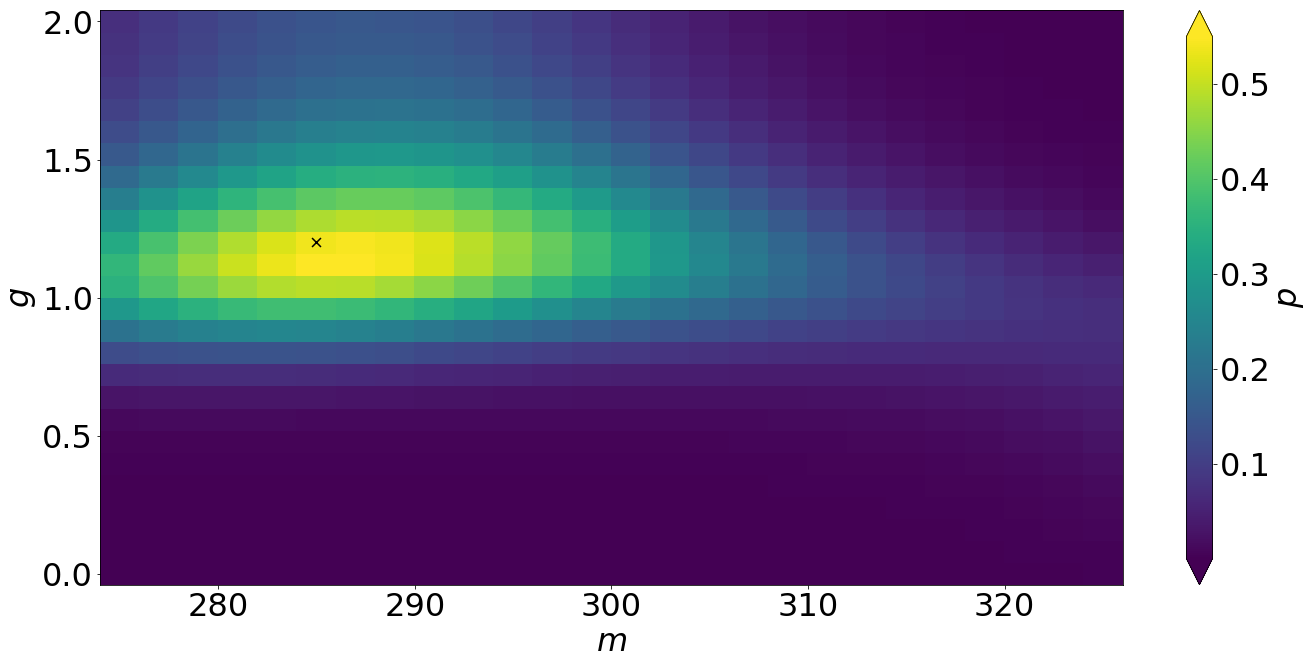

In [125]:
pvals_invm = run_pseudoexperiments(log_r_hat_invm, theta_m.shape[0],theta_g.shape[0], n_test_events, n_experiments)

fig = plt.figure(figsize=(20,10))
ax = plt.gca()
cmin, cmax = np.min(pvals_invm), np.max(pvals_invm)
pcm = ax.pcolormesh(edges_m, edges_g, pvals_invm,
                    norm=matplotlib.colors.Normalize(vmin=cmin, vmax=cmax),
                    cmap='viridis')
cbar = fig.colorbar(pcm, ax=ax, extend='both')

plt.scatter(sampler.benchmarks[testing_theta_true]['mzp'], sampler.benchmarks[testing_theta_true]['gzp'], s=80., color='black', marker='x')

plt.xlabel(r'$m$')
plt.ylabel(r'$g$')
cbar.set_label(r'$p$')

plt.tight_layout()
plt.show()

We also show this result at lower resolution so that it can be directly compared to the histogram result.

02:49 madminer.ml          INFO    Loading evaluation data
02:49 madminer.ml          INFO    Starting ratio evaluation for 1210000 x-theta combinations
02:49 madminer.ml          INFO    Evaluation done


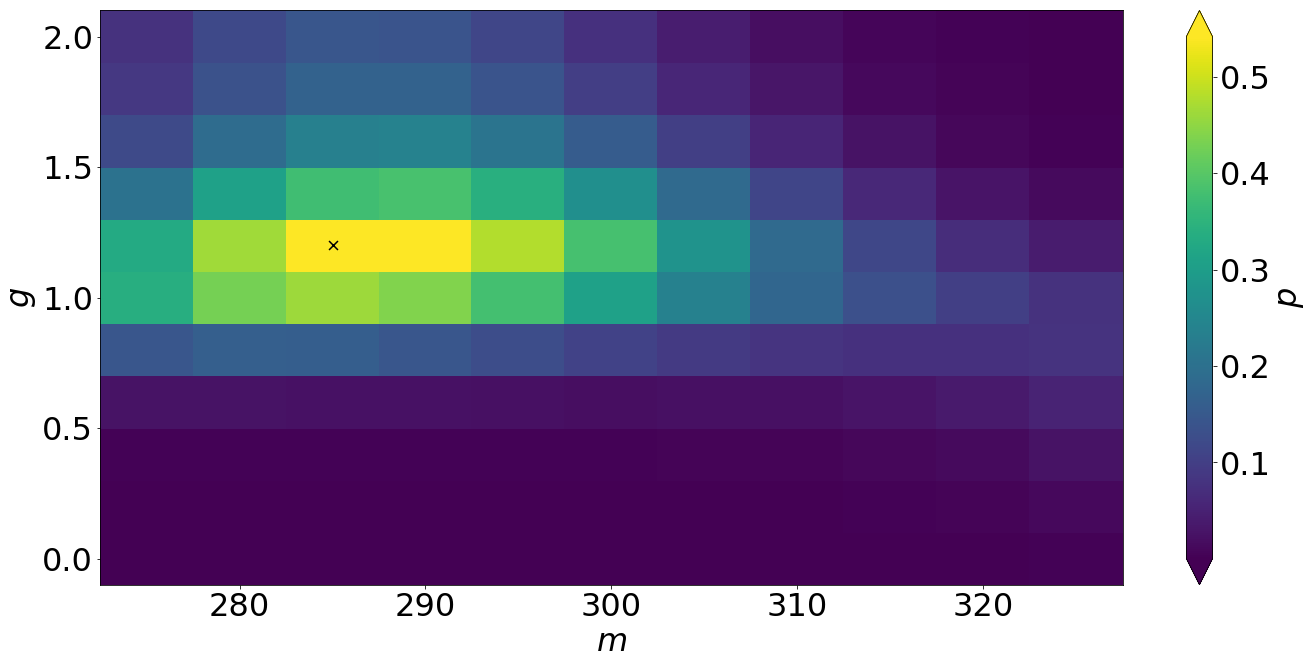

In [126]:
log_r_hat_invm_lowres, _ = invm_estimator.evaluate_log_likelihood_ratio(
    theta=theta_grid_lowres,
    x=calculate_invariant_mass(x_test),
    evaluate_score=False,
    test_all_combinations=True
)

pvals_invm_lowres = run_pseudoexperiments(log_r_hat_invm_lowres, theta_m_lowres.shape[0],theta_g_lowres.shape[0], n_test_events, n_experiments)

fig = plt.figure(figsize=(20,10))
ax = plt.gca()
cmin, cmax = np.min(pvals_invm_lowres), np.max(pvals_invm_lowres)
pcm = ax.pcolormesh(edges_m_lowres, edges_g_lowres, pvals_invm_lowres,
                    norm=matplotlib.colors.Normalize(vmin=cmin, vmax=cmax),
                    cmap='viridis')
cbar = fig.colorbar(pcm, ax=ax, extend='both')

plt.scatter(sampler.benchmarks[testing_theta_true]['mzp'], sampler.benchmarks[testing_theta_true]['gzp'], s=80., color='black', marker='x')

plt.xlabel(r'$m$')
plt.ylabel(r'$g$')
cbar.set_label(r'$p$')

plt.tight_layout()
plt.savefig('figures/invm_ALICE_pvals.png', format='png')
#plt.savefig('figures/invm_ALICE_pvals.svg', format='svg')
plt.show()

## ALICE result on invariant mass + $\Delta y_{jj}$

We discover that the extra information is held in $\Delta y_{jj}$ by repeating the invariant mass analysis with $\Delta y_{jj}$ added to the input.

In [39]:
twod_estimator = ParameterizedRatioEstimator(
    n_hidden=(8,8,8),
)
x_twod =twod_data(x)

train_loss, val_loss = twod_estimator.train(
    method='alice',
    theta=theta0,
    x=x_twod,
    y=y,
    r_xz=r_xz,
    initial_lr = .0023,
    final_lr = .00004,
    batch_size = 128,
    optimizer='amsgrad',
    n_epochs=100,
    limit_samplesize=1000000,
    scale_parameters=True
)
    
#twod_estimator.save('models/alice_twod')

In [98]:
twod_estimator = ParameterizedRatioEstimator(
    n_hidden=(8,8,8),
)
twod_estimator.load('models/alice_twod')

log_r_hat_twod, _ = twod_estimator.evaluate_log_likelihood_ratio(
    theta=theta_grid,
    x=twod_data(x_test),
    evaluate_score=False,
    test_all_combinations=True
)

01:45 madminer.ml          INFO    Loading model from models/alice_twod
01:45 madminer.ml          INFO    Loading evaluation data
01:45 madminer.ml          INFO    Starting ratio evaluation for 6760000 x-theta combinations
01:46 madminer.ml          INFO    Evaluation done


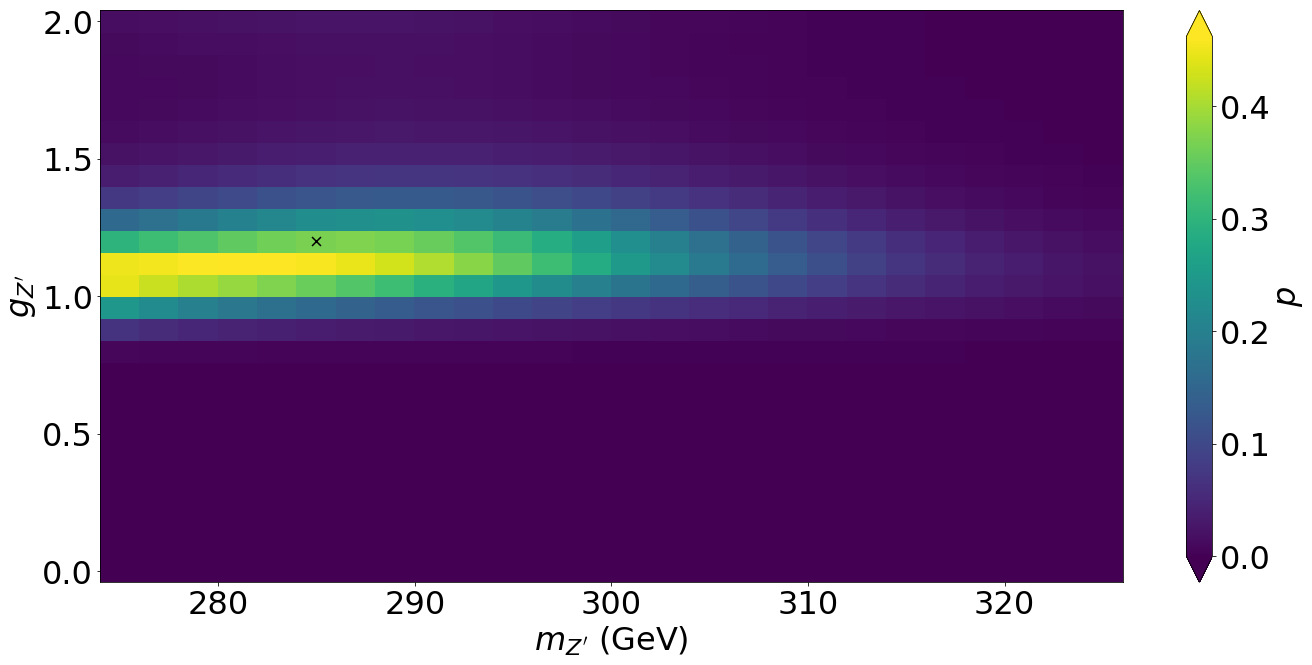

In [127]:
pvals_twod = run_pseudoexperiments(log_r_hat_twod, theta_m.shape[0],theta_g.shape[0], n_test_events, n_experiments)

fig = plt.figure(figsize=(20,10))
ax = plt.gca()

cmin, cmax = np.min(pvals_twod), np.max(pvals_twod)
pcm_twod = ax.pcolormesh(edges_m, edges_g, pvals_twod,
                    norm=matplotlib.colors.Normalize(vmin=cmin, vmax=cmax),
                    cmap='viridis')
cbar = fig.colorbar(pcm_twod, ax=ax, extend='both')

plt.scatter(sampler.benchmarks[testing_theta_true]['mzp'], sampler.benchmarks[testing_theta_true]['gzp'], s=80., color='black', marker='x')
plt.rcParams.update({'font.size': 32})
plt.xlabel(r"$m_{Z'}$ (GeV)")
plt.ylabel(r"$g_{Z'}$")
cbar.set_label(r'$p$')

plt.tight_layout()
plt.savefig('figures/2D_ALICE_pvals.png', format='png')
#plt.savefig('figures/2D_ALICE_pvals.svg', format='svg')
plt.show()

## Exclusion Contour Comparison

We plot the 1$\sigma$ and 2$\sigma$ exlclusion contours for all likelihood ratios found so far.

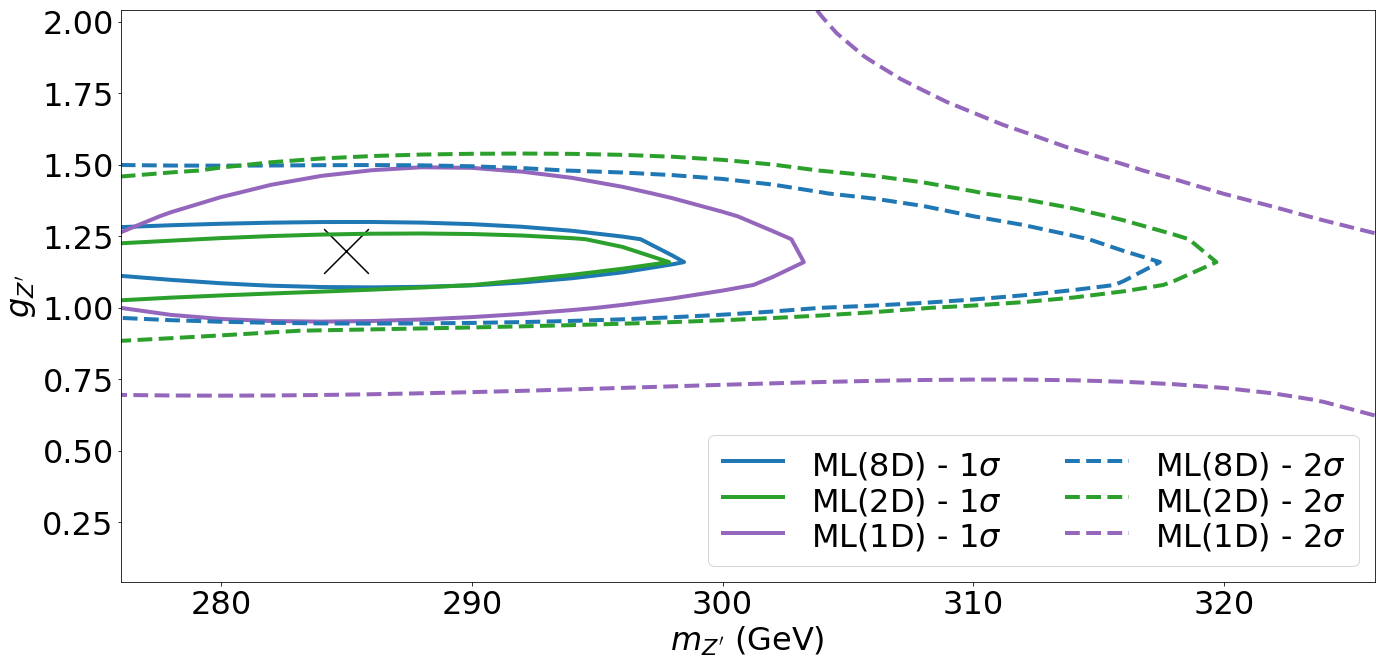

In [114]:
pvals_oned = pvals_invm
pvals_twod = pvals_twod
pvals_eightd = pvals

XX,YY = np.meshgrid(edges_m[1:],edges_g[1:])
exclusion_contours_eightd = 1-pvals_eightd
exclusion_contours_twod = 1-pvals_twod
exclusion_contours_oned = 1-pvals_oned

fig = plt.figure(figsize=(20,10))
ax = plt.gca()

cntr1=plt.contour(XX,YY,exclusion_contours_eightd, levels=[0.682689492137086], colors='C0',linewidths=4, label= r'x - $1\sigma$' )
cntr2=plt.contour(XX,YY,exclusion_contours_twod, levels=[0.682689492137086], colors='C2', linewidths=4, label= r'$m_{jj}$ - $1\sigma$' )
cntr3=plt.contour(XX,YY,exclusion_contours_oned, levels=[0.682689492137086], colors='C4', linewidths=4, label= r'$m_{jj}$ - $1\sigma$' )

cntr4=plt.contour(XX,YY,exclusion_contours_eightd, levels=[0.954499736103642], colors='C0',linewidths=4, linestyles='dashed', label= r'x - $3\sigma$'  )
cntr5=plt.contour(XX,YY,exclusion_contours_twod, levels=[0.954499736103642], colors='C2', linewidths=4, linestyles='dashed', label= r'$m_{jj}$ - $3\sigma$' )
cntr6=plt.contour(XX,YY,exclusion_contours_oned, levels=[0.954499736103642], colors='C4', linewidths=4, linestyles='dashed', label= r'$m_{jj}$ - $3\sigma$' )
h1,_ = cntr1.legend_elements()
h2,_ = cntr2.legend_elements()
h3,_ = cntr3.legend_elements()
h4,_ = cntr4.legend_elements()
h5,_ = cntr5.legend_elements()
h6,_ = cntr6.legend_elements()
ax.legend([h1[0], h2[0],h3[0], h4[0], h5[0], h6[0]], [r'ML(8D) - $1\sigma$', r'ML(2D) - $1\sigma$' ,r'ML(1D) - $1\sigma$', r'ML(8D) - $2\sigma$', r'ML(2D) - $2\sigma$', r'ML(1D) - $2\sigma$'], loc='lower right',handleheight=1.2, labelspacing=.05, ncol=2)


plt.scatter(sampler.benchmarks[testing_theta_true]['mzp'], sampler.benchmarks[testing_theta_true]['gzp'], s=2000., color='black', marker='x')
plt.rcParams.update({'font.size': 32})
plt.xlabel(r"$m_{Z'}$ (GeV)")
plt.ylabel(r"$g_{Z'}$")
cbar.set_label(r'$p$')

plt.tight_layout()
plt.savefig('figures/exclusion_contours_comparison.png', format='png')
#plt.savefig('figures/exclusion_contours_comparison.svg', format='svg')
plt.show()